In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from cross_sections import (
    gen_cross_section_compton,
    gen_cross_section_pairproduction,
    load_pairproduction_cross_section,
)
from acceptance import SRXMData, foil_trace, Foil, aperture
from physical_constants import mol, MeV, millimeter, centimeter


###################
def run_sim():
    x_number_density = x_density * 1e6 / x_atomic_weight * mol  # [/m^3]

    with open(f"./_data/estar_{material_name}.txt", "r", encoding="utf8") as srem:
        x_srem = np.array(
            [[float(y) for y in x.split(" ")[:2]] for x in srem.readlines()[9:]]
        )
        x_srem[:, 0] *= MeV  #  MeV  ->  J
        x_srem[:, 1] *= x_density * MeV / centimeter  #  MeV cm^2 / g  ->  J / m
        # x_srem[:, 1] *= 0.2  # !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
        x_srem: SRXMData = x_srem[:, 0], x_srem[:, 1]

    x_crosssection_compton = gen_cross_section_compton(
        x_number_density * Z,
        np.linspace(15, 17, 3) * MeV,
        np.linspace(0.0, np.pi, 1000),
    )
    x_crosssection_pairproduction = gen_cross_section_pairproduction(
        Z,
        x_number_density,
        load_pairproduction_cross_section("./_data/pairprod_xsctn_medium.npz"),
    )
    x_foil: Foil = x_srem, [
        x_crosssection_compton,
        x_crosssection_pairproduction,
    ]

    elec_angle, elec_energy, ids = foil_trace(
        n_rays_incident=N,
        n_srxm_steps=100,
        phot_energy_in=16 * MeV,
        foil_properties=x_foil,
        foil_depth=x_depth_mm * millimeter,
    )

    print(f"------ {material_name} {x_depth_mm}mm ------")
    print(f"pre-aperture efficiency: {elec_energy.size / N}")

    foil_area = 3.14159 * (R_FOIL / 1e-2) ** 2
    gamma_per_cm2_MW = 1.5e3

    t, p, x, y, en, i = aperture(
        (elec_angle, elec_energy, ids), R_FOIL, R_APERTURE, R_APERTURE
    )
    print(f"post-aperture efficiency: {en.size / N}  [1/{N / en.size }]")
    print(f"electrons per megawatt: {(en.size / N) * gamma_per_cm2_MW * foil_area}")
    print(f"electrons @140MW: {(en.size / N) * gamma_per_cm2_MW * foil_area * 140}")
    print(
        f"post-aperture efficiency [compton only]: {en[i==0].size / N}  [1/{N / en[i==0].size }]"
    )
    print(
        f"electrons per megawatt [compton only]: {(en[i==0].size / N) * gamma_per_cm2_MW * foil_area}"
    )
    print(
        f"electrons @140MW [compton only]: {(en[i==0].size / N) * gamma_per_cm2_MW * foil_area * 140}"
    )

    print(
        f"[{np.min(en[i==0])/MeV} : {np.max(en[i==0])/MeV}] [{np.min(en[i==1])/MeV} : {np.max(en[i==1])/MeV}]"
    )

    # plt.hist2d(elec_angle[ids==0], elec_energy[ids==0] / MeV, bins=150)
    # plt.title(f"{material_name[0].upper()}{material_name[1:]} {x_depth_mm}mm, 16MeV gamma, compton only")
    # # plt.title(f"{16}MeV gamma, compton only")
    # plt.xlabel("electron angle /rad")
    # plt.ylabel("electron energy /MeV")
    # plt.show()
    # # plt.cla()
    # # # plt.hist([en[i == 0] / MeV, en[i == 1] / MeV], bins=250, stacked=True)
    # # plt.hist([en[i == 0] / MeV, en[i == 1] / MeV], bins=int(16 / 0.150), stacked=True)
    # # plt.title(
    # #     f"post-aperture electron energy\n[{material_name[0].upper()}{material_name[1:]} {x_depth_mm}mm; foil r={R_FOIL/0.01}cm, drift {R_APERTURE/0.01}cm, aperture r={R_APERTURE}]"
    # # )
    # # plt.legend(["compton", "pair production"])
    # # plt.xlabel("electron energy /MeV")
    # # plt.ylabel("counts")
    # # plt.show()
    # # plt.cla()
    return (
        en[i==0].size / N, # compton efficiency
        (en[i==0].size / N) * gamma_per_cm2_MW * foil_area, # counts/s/MW
        en[i==0].size / en[i==1].size, # compton/pairprod snr
    )


R_FOIL = 0.015
L_DRIFT = 0.25
R_APERTURE = 0.015
N_BY_Z = 1000_000_000

a0 = []

all_Z = [3,4,6,16,26,79]

# for x_depth_mm in [0.1, 1, 10]:
# for x_depth_mm in [0.1, 0.25, 0.5, 1, 2, 4, 10]:
for x_depth_mm in [0.1, 0.2,0.4, 0.6,0.8, 1, 2, 3,4,5]:
    a1 = []
    a0.append(a1)

    Z = 3
    N = N_BY_Z / Z / x_depth_mm
    x_density = 0.5334  # [g/cm^3]
    x_atomic_weight = 6.94  # [amu | g/mol]
    material_name = "li"
    a1.append(run_sim())

    Z = 4
    N = N_BY_Z / Z / x_depth_mm
    x_density = 1.845  # [g/cm^3]
    x_atomic_weight = 9.0122  # [amu | g/mol]
    material_name = "be"
    a1.append(run_sim())

    Z = 6
    N = N_BY_Z / Z / x_depth_mm
    x_density = 2.18  # [g/cm^3]
    x_atomic_weight = 12.011  # [amu | g/mol]
    material_name = "graphite"
    a1.append(run_sim())

    Z = 16
    N = N_BY_Z / Z / x_depth_mm
    x_density = 2.329085  # [g/cm^3]
    x_atomic_weight = 28.085  # [amu | g/mol]
    material_name = "si"
    a1.append(run_sim())

    Z = 26
    N = N_BY_Z / Z / x_depth_mm
    x_density = 7.874  # [g/cm^3]
    x_atomic_weight = 55.845  # [amu | g/mol]
    material_name = "fe"
    a1.append(run_sim())

    Z = 79
    N = N_BY_Z / Z / x_depth_mm
    x_density = 19.283  # [g/cm^3]
    x_atomic_weight = 196.966570  # [amu | g/mol]
    material_name = "au"
    a1.append(run_sim())

a0 = np.array(a0)

/home/skylol/Desktop/school/U0/code/mer_prototype/util.py:88: RuntimeWarning: invalid value encountered in divide
  return np.transpose(x / x[-1], axes=axes)


------ li 0.1mm ------
pre-aperture efficiency: 5.9902500000000005e-05
post-aperture efficiency: 4.3736700000000004e-05  [1/22864.093541579496]
electrons per megawatt: 0.4637343803163751
electrons @140MW: 64.92281324429251
post-aperture efficiency [compton only]: 3.2905500000000005e-05  [1/30390.05637355457]
electrons per megawatt [compton only]: 0.34889261538937505
electrons @140MW [compton only]: 48.844966154512505
[0.21777110689055568 : 15.748439959980214] [0.022784182916482997 : 14.921812717438353]
------ be 0.1mm ------
pre-aperture efficiency: 0.0002237536
post-aperture efficiency: 0.000168414  [1/5937.748643224435]
electrons per megawatt: 1.7856711166274999
electrons @140MW: 249.99395632785
post-aperture efficiency [compton only]: 0.0001169376  [1/8551.569384013354]
electrons per megawatt [compton only]: 1.2398737323959999
electrons @140MW [compton only]: 173.58232253543997
[0.1798282135002338 : 15.74851090408256] [0.01953149460988744 : 14.959674502325266]
------ graphite 0.1mm 

In [2]:
a0

array([[[3.29544000e-05, 3.49411096e-01, 3.02878571e+00],
        [1.16886000e-04, 1.23932662e+00, 2.27447150e+00],
        [1.55899200e-04, 1.65297837e+00, 1.51882811e+00],
        [1.88844800e-04, 2.00229616e+00, 5.68026720e-01],
        [5.22124200e-04, 5.53601306e+00, 3.48842905e-01],
        [1.09401570e-03, 1.15997021e+01, 1.14772685e-01]],

       [[8.25510000e-05, 8.75277212e-01, 3.03627486e+00],
        [2.91726000e-04, 3.09313176e+00, 2.27257572e+00],
        [3.89853000e-04, 4.13355922e+00, 1.52563147e+00],
        [4.74052000e-04, 5.02630995e+00, 5.69470139e-01],
        [1.30065000e-03, 1.37906180e+01, 3.49345741e-01],
        [2.68912050e-03, 2.85123850e+01, 1.14134494e-01]],

       [[1.65109500e-04, 1.75063395e+00, 3.04886021e+00],
        [5.86106000e-04, 6.21440353e+00, 2.28661829e+00],
        [7.74288000e-04, 8.20967210e+00, 1.51423023e+00],
        [9.42840000e-04, 9.99680642e+00, 5.65675037e-01],
        [2.56488700e-03, 2.71951538e+01, 3.46396267e-01],
        [5

Text(0.5, 1.0, 'compton signal to pair-production noise ratio vs atomic number')

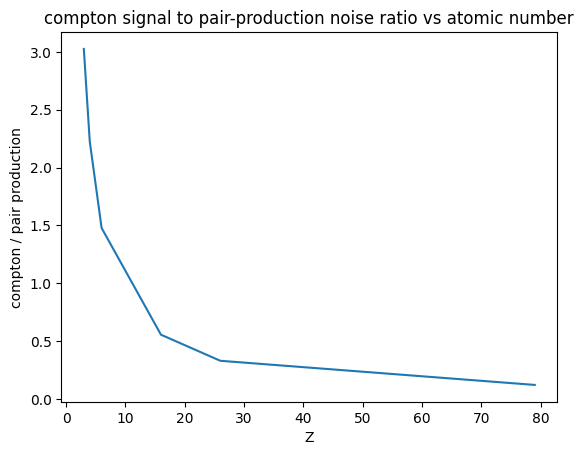

In [3]:
# plt.plot(all_Z, a0[0,:,2])
# plt.plot(all_Z, a0[1,:,2])
# plt.plot(all_Z, a0[2,:,2])
# plt.plot(all_Z, a0[3,:,2])
# plt.plot(all_Z, a0[4,:,2])
plt.plot(all_Z, a0[5,:,2])
plt.xlabel("Z")
plt.ylabel("compton / pair production")
plt.title("compton signal to pair-production noise ratio vs atomic number")


Text(0.5, 1.0, 'post-aperture electron count vs foil depth')

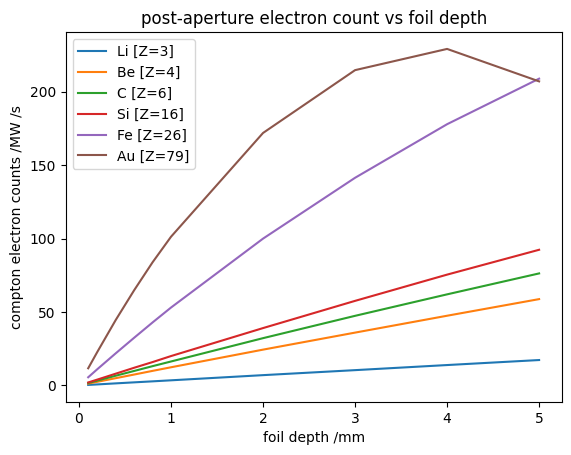

In [7]:
# fdepths = [0.1, 0.25, 0.5, 1, 2, 4, 10]
fdepths = [0.1, 0.2,0.4, 0.6,0.8, 1, 2, 3,4,5]
plt.plot(fdepths, a0[:,0,1])
plt.plot(fdepths, a0[:,1,1])
plt.plot(fdepths, a0[:,2,1])
plt.plot(fdepths, a0[:,3,1])
plt.plot(fdepths, a0[:,4,1])
plt.plot(fdepths, a0[:,5,1])
plt.xlabel("foil depth /mm")
plt.ylabel("compton electron counts /MW /s")
# plt.yscale("log")
plt.legend([
    "Li [Z=3]",
    "Be [Z=4]",
    "C [Z=6]",
    "Si [Z=16]",
    "Fe [Z=26]",
    "Au [Z=79]",
])
plt.title("post-aperture electron count vs foil depth")


Text(0.5, 1.0, 'post-aperture electron counts at 140MW vs foil depth')

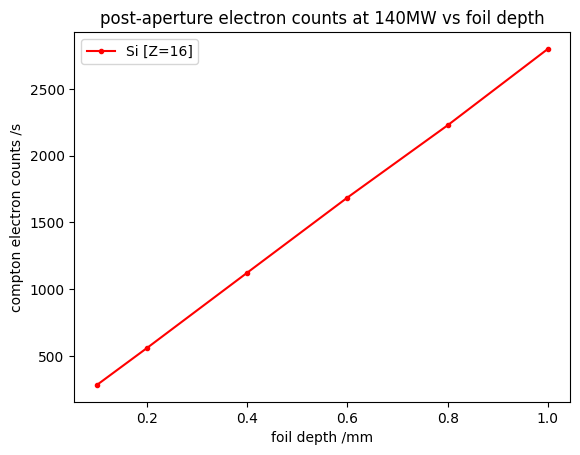

In [11]:
# fdepths = [0.1, 0.25, 0.5, 1, 2, 4, 10][:4]
fdepths = [0.1, 0.2,0.4, 0.6,0.8, 1, 2, 3,4,5][:6]
plt.plot(fdepths, a0[:6,3,1]*140, ".r-")
plt.xlabel("foil depth /mm")
plt.ylabel("compton electron counts /s")
# plt.yscale("log")
plt.legend([
    "Si [Z=16]",
])
plt.title("post-aperture electron counts at 140MW vs foil depth")
